In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/AN2DL/Homework2

Mounted at /gdrive
/gdrive/MyDrive/AN2DL/Homework2


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [5]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(training_data)

[[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
 [0.         0.         0.         ... 0.6        0.46       0.396     ]
 [0.         0.         0.         ... 0.96048126 0.94650625 0.97714021]
 ...
 [0.         0.         0.         ... 0.52631579 0.58223684 0.55263158]
 [0.         0.         0.         ... 0.44559585 0.58549223 0.40414508]
 [0.         0.         0.         ... 0.54268293 0.6097561  0.59146341]]


In [6]:
training_data.shape

(48000, 2776)

In [7]:
def print_sequence(dataset, to_plot):
  figs, axs = plt.subplots(to_plot, 1, sharex=True, figsize=(17,17))
  n_elements = len(dataset)
  for i in range(to_plot):
    el = random.randrange(n_elements)
    axs[i].plot(dataset[el])
    axs[i].set_title(el)
  plt.show()

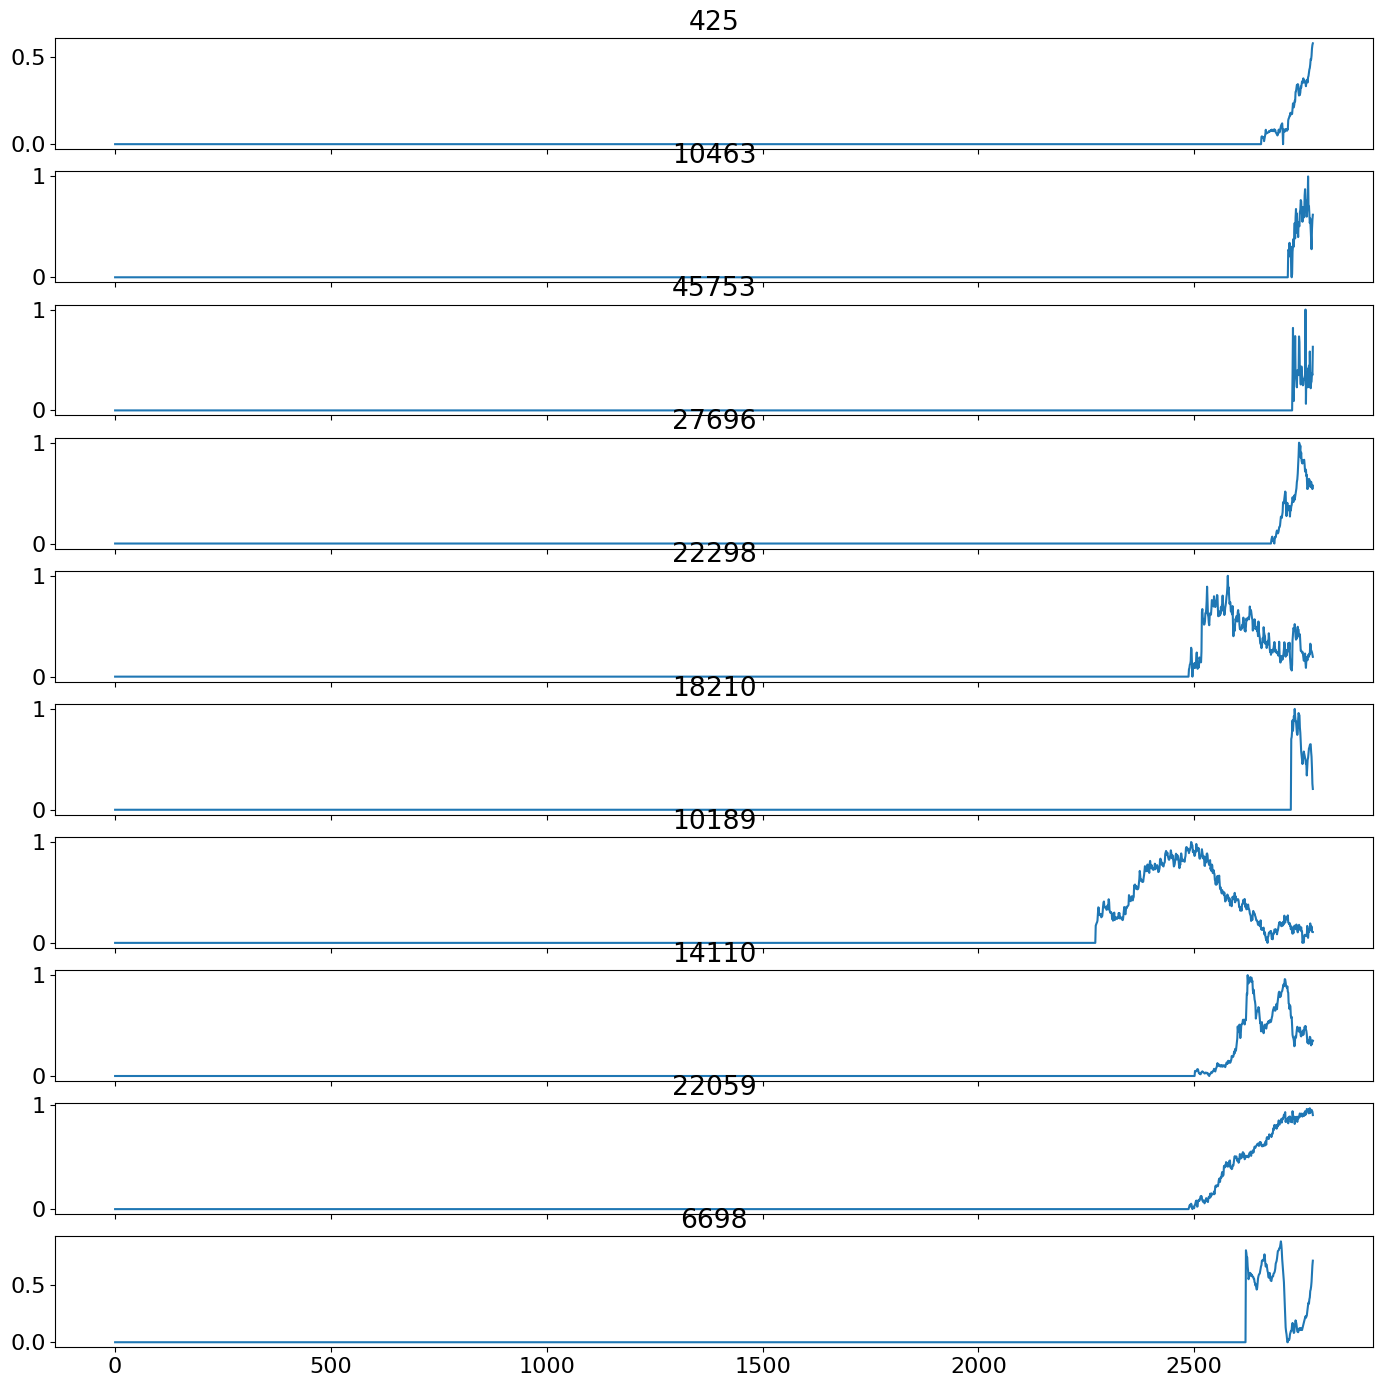

In [26]:
print_sequence(training_data, 10)

In [27]:
dataset = training_data

In [28]:
categories = np.load("categories.npy", allow_pickle=True)
valid_periods = np.load("valid_periods.npy", allow_pickle=True)
categories_Set = set(categories)

dataset = []
for i in range(training_data.shape[0]):
    start = valid_periods[i][0]
    ending = valid_periods[i][1]
    if ending - start > 218:
      dataset.append(training_data[i][start : ending])


In [29]:
print(len(dataset))

19802


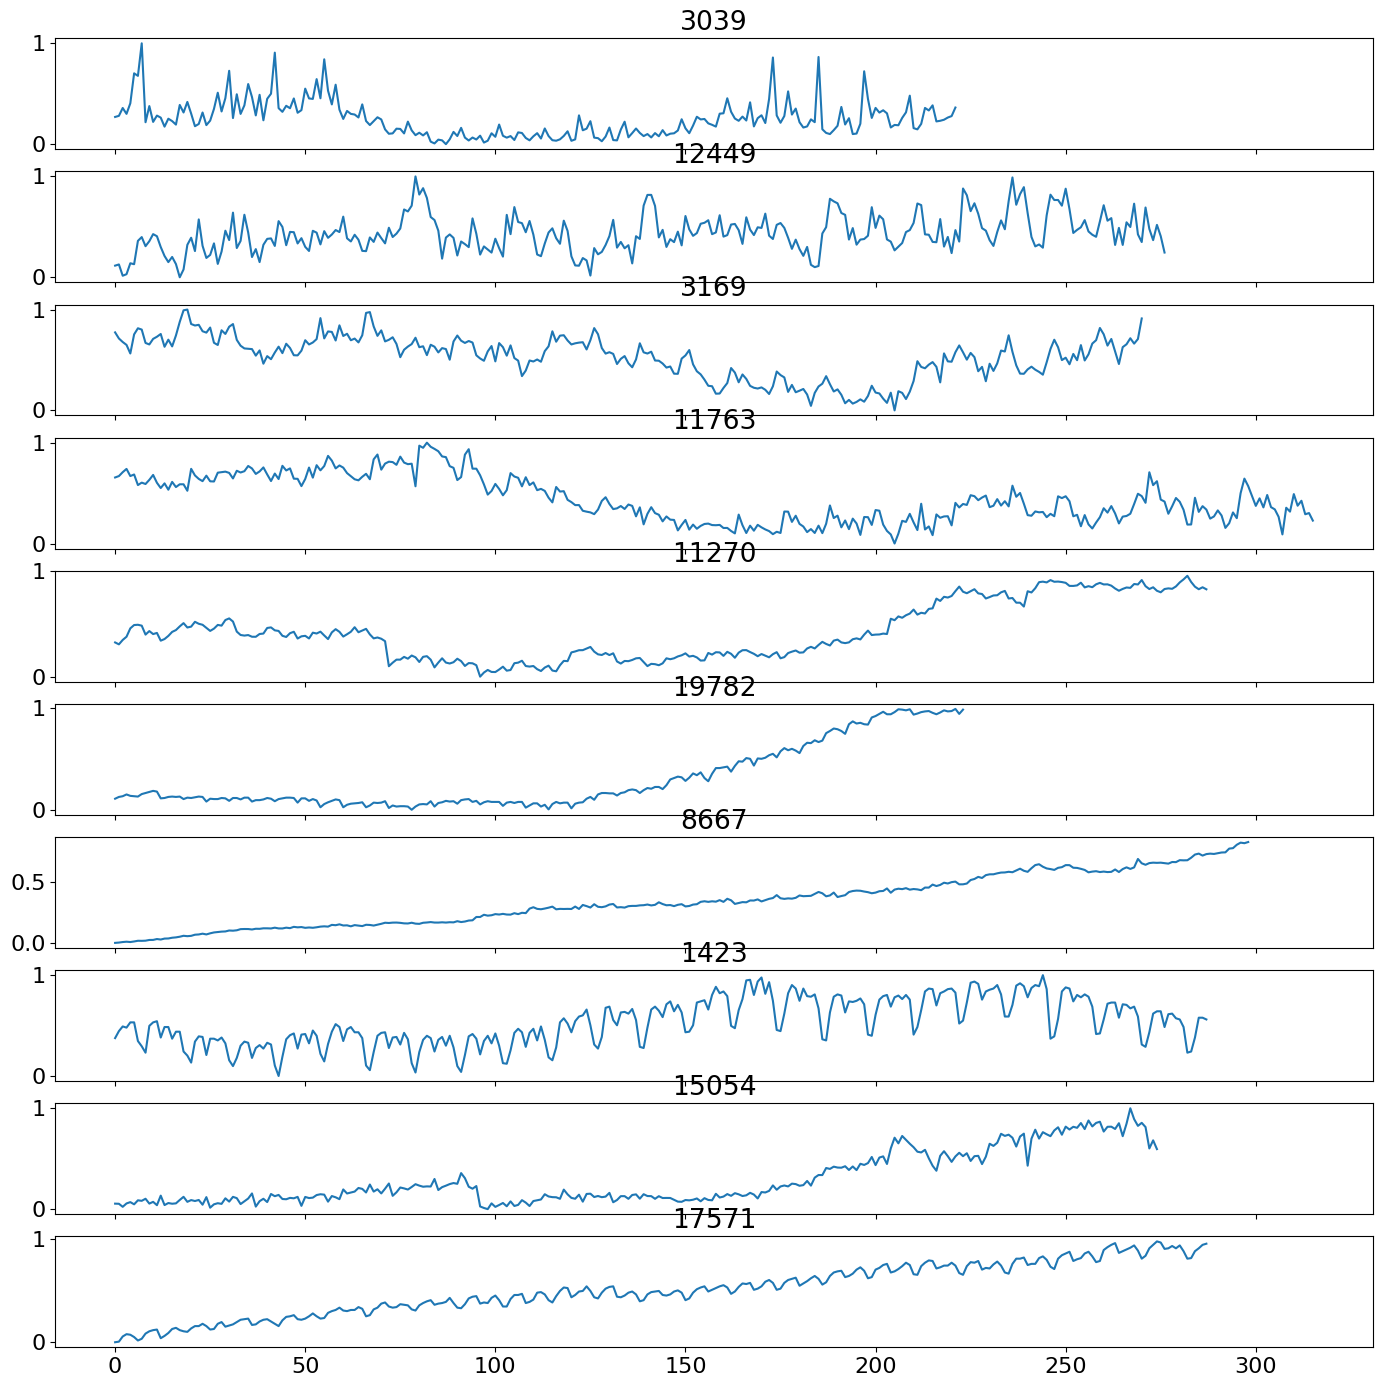

In [30]:
print_sequence(dataset, 10)

In [31]:
def split_train_test(dataset, percentage):
  X_train = []
  X_test = []
  for i in range(len(dataset)):
    pos = int(len(dataset[i])* percentage)
    train_el = dataset[i][:pos]
    test_el = dataset[i][pos:]
    X_train.append(train_el)
    X_test.append(test_el)
  return X_train, X_test

In [32]:
from sklearn.model_selection import train_test_split
X_test, X_train = train_test_split(dataset, test_size=0.80)
print(len(X_train))
print(len(X_test))

15842
3960


In [33]:
def build_sequences(df, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for el in range(len(df)):
      element = df[el]
      lenght = len(element)
      starting = 0
      ending_w = starting + window
      ending_t = ending_w + telescope
      while True:
        if ending_t > lenght:
          break
        dataset.append(element[starting:ending_w])
        labels.append(element[ending_w:ending_t])
        starting = starting + stride
        ending_w = starting + window
        ending_t = ending_w + telescope

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [34]:
window = 200
stride = 50
telescope = 18
X_train, y_train = build_sequences(X_train, window, stride, telescope)
X_test, y_test = build_sequences(X_test, window, stride, telescope)

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42307, 200)
(42307, 18)
(10691, 200)
(10691, 18)


In [36]:
#X_test = pd.DataFrame(X_test)

In [37]:
# from sklearn.preprocessing import RobustScaler
# x_scaler = RobustScaler()
# y_scaler = RobustScaler()
# X_train = x_scaler.fit_transform(X_train)
# y_train = y_scaler.fit_transform(y_train)
# X_test = x_scaler.transform(X_test)

In [38]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train,axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [39]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [40]:
print(input_shape)
print(output_shape)

print(input_shape[0] >= output_shape[0])

(200, 1)
(18, 1)
True


In [41]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    x = tfkl.Conv1D(512, 3, padding='same', activation='relu', name='conv_1')(x)

    x = tfkl.Conv1D(256, 3, padding='same', activation='relu', name='conv_2')(x)
    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]
    print(output_layer.shape[1])

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    return model

200
Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 256)          133120    
 ctional)                                                        
                                                                 
 bidirectional_lstm_2 (Bidi  (None, 200, 512)          1050624   
 rectional)                                                      
                                                                 
 conv_1 (Conv1D)             (None, 200, 512)          786944    
                                                                 
 conv_2 (Conv1D)             (None, 200, 256)          393472    
                                                                 
 conv (Conv1D)               (None, 200, 128)  

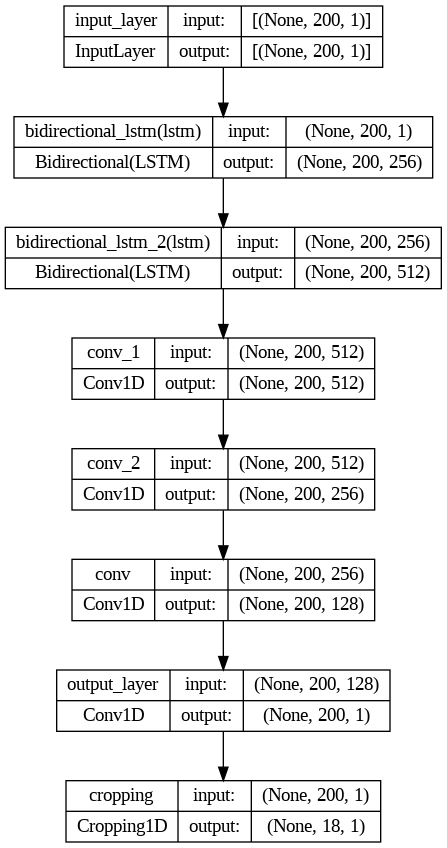

In [42]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [43]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=14, restore_best_weights=True, min_delta=0.00005),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.5, min_lr=1e-7)
    ]
).history

Epoch 1/200
595/595 [==============================] - 60s 88ms/step - loss: 0.0706 - val_loss: 0.0617 - lr: 0.0010
Epoch 2/200
595/595 [==============================] - 50s 84ms/step - loss: 0.0633 - val_loss: 0.0641 - lr: 0.0010
Epoch 3/200
595/595 [==============================] - 50s 85ms/step - loss: 0.0646 - val_loss: 0.0643 - lr: 0.0010
Epoch 4/200
595/595 [==============================] - 50s 85ms/step - loss: 0.0312 - val_loss: 0.0122 - lr: 0.0010
Epoch 5/200
595/595 [==============================] - 50s 85ms/step - loss: 0.0122 - val_loss: 0.0120 - lr: 0.0010
Epoch 6/200
595/595 [==============================] - 50s 85ms/step - loss: 0.0119 - val_loss: 0.0114 - lr: 0.0010
Epoch 7/200
595/595 [==============================] - 50s 85ms/step - loss: 0.0116 - val_loss: 0.0112 - lr: 0.0010
Epoch 8/200
595/595 [==============================] - 50s 85ms/step - loss: 0.0115 - val_loss: 0.0111 - lr: 0.0010
Epoch 9/200
595/595 [==============================] - 51s 85ms/step - l

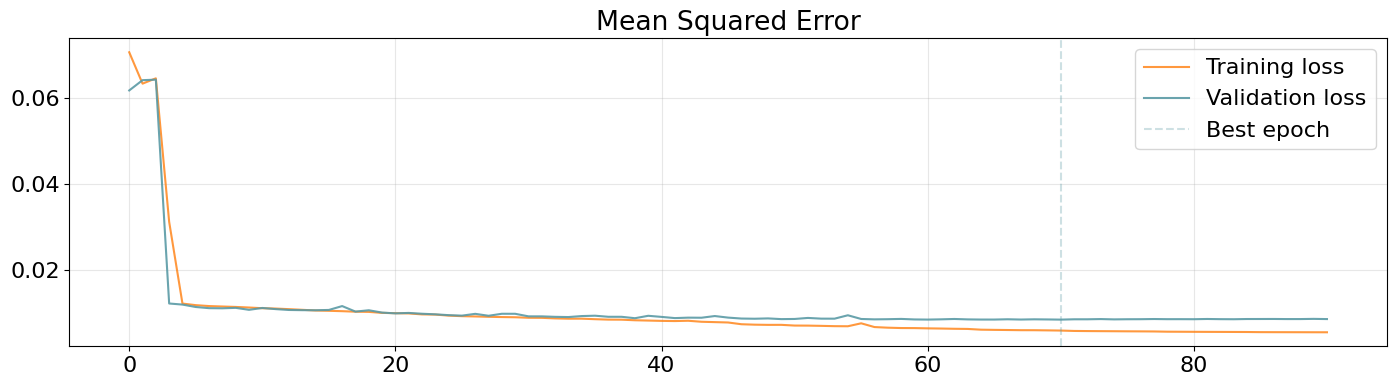

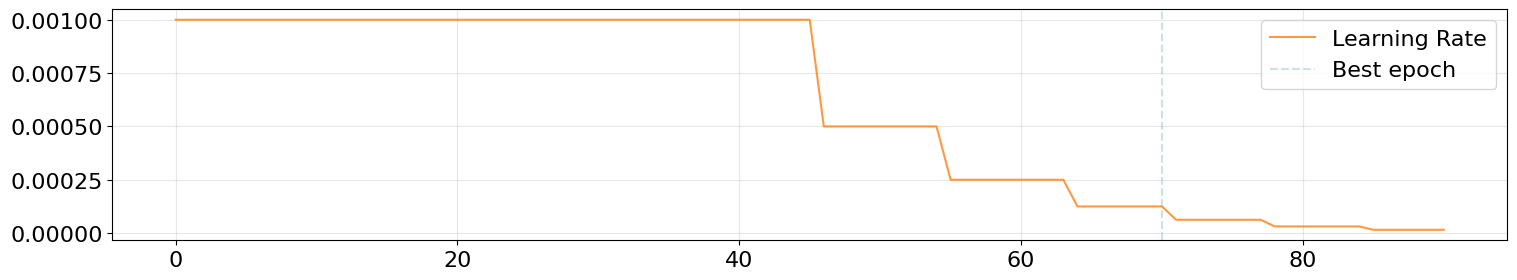

In [44]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [46]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (10691, 18, 1)
Mean Squared Error: 0.008573964238166809
Mean Absolute Error: 0.06052972376346588


In [47]:
 model.save('BidirectionalLSTM_V3')